In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")


import os
import random
import tensorflow as tf

# 1. Set Python seed
random.seed(42)

# 2. Set NumPy seed
np.random.seed(42)

# 3. Set TensorFlow seed
tf.random.set_seed(42)

In [12]:
# features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'MA5', 'MA10', 'Volatility']
features = ['Open', 'High', 'Low', 'Close','MA10', 'Target']

In [16]:
train_df = pd.read_csv(r'D:\Cloudly IO\Tesla-Forcasting-Project\data\preprocessed\Tasla_Stock_Updated_train.csv')[features]
test_df = pd.read_csv(r'D:\Cloudly IO\Tesla-Forcasting-Project\data\preprocessed\Tasla_Stock_Updated_test.csv')[features]

train_data = train_df
test_data = test_df

In [17]:
train_df.head()

,Open,High,Low,Close,MA10,Target
0,12.966000,13.050000,12.666667,12.791333,13.732867,12.871333
1,12.713333,12.966000,12.643333,12.871333,13.557933,12.795333
2,12.924667,12.941333,12.469333,12.795333,13.436866,13.104667
3,12.636667,13.245333,12.634000,13.104667,13.338800,13.441333
4,13.133333,13.549333,13.013333,13.441333,13.276600,13.419333


In [18]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Separate features and target
X_train = train_data.drop(['Target'], axis=1)
y_train = train_data['Target']

X_test = test_data.drop(['Target'], axis=1)
y_test = test_data['Target']

# Scale features
scaler_X = StandardScaler()
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=X_test.columns, index=X_test.index)

# Scale target
scaler_y = StandardScaler()
y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train.values.reshape(-1, 1)), columns=['Target'], index=y_train.index)
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test.values.reshape(-1, 1)), columns=['Target'], index=y_test.index)


In [19]:
y_train_scaled

,Target
0,-0.599204
1,-0.599979
2,-0.596825
3,-0.593391
4,-0.593616
...,...
1804,2.232446
1805,2.347312
1806,2.400920
1807,2.648464


# Model evaluation

In [30]:
def loss_curve(history):
  # 1. Access loss values
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # 2. Plot it
  plt.figure(figsize=(10, 6))
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title('Neural Network Loss Curve')
  plt.xlabel('Epochs')
  plt.ylabel('MSE Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [20]:
def evaluate_model(model, X_test, y_test):
  # Evaluation Metrics
  y_pred = model.predict(X_test)
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred)

  print(f"MAE: {mae:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R² Score: {r2:.2f}")

  # Visual Comparison
  plt.figure(figsize=(20,5))
  plt.plot(y_test.values, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.title("Actual vs Predicted Tesla Monthly Closing Price")
  plt.legend()
  plt.show()


# XGBoost

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train the model
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

MAE: 0.08
RMSE: 0.11
R² Score: 0.95


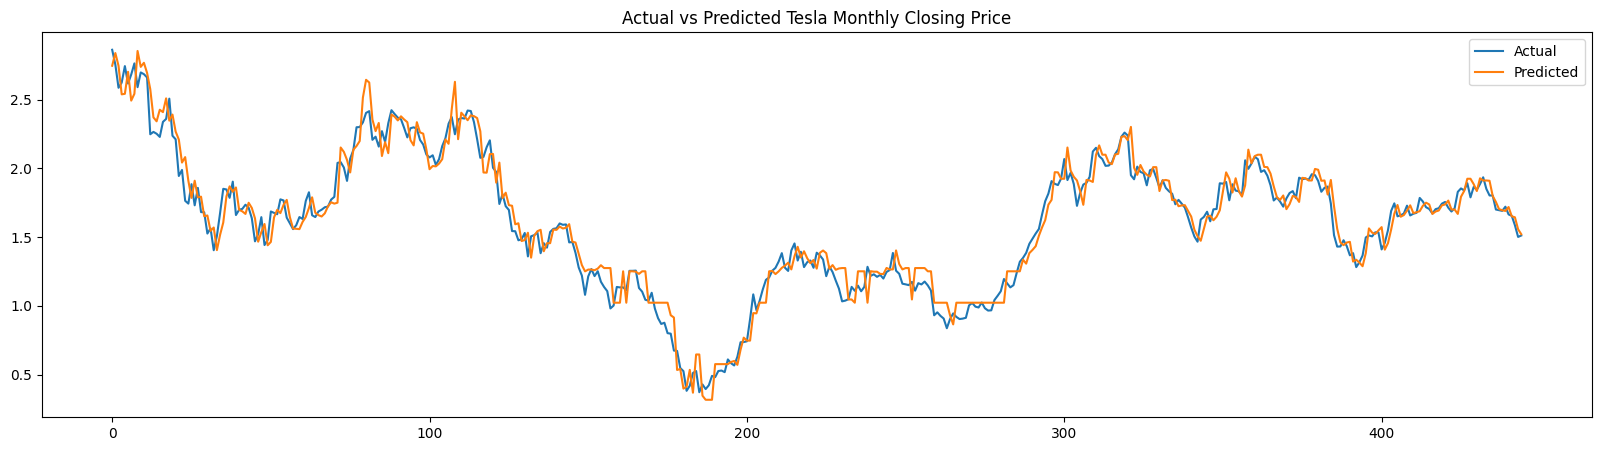

In [22]:
evaluate_model(model_xgb, X_test_scaled, y_test_scaled)

In [24]:
joblib.dump(model_xgb, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_xgb.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_xgb.pkl']

# Linear regression

In [25]:
from sklearn.linear_model import LinearRegression

model_lnr = LinearRegression()
model_lnr.fit(X_train_scaled, y_train_scaled)


LinearRegression()

MAE: 0.06
RMSE: 0.09
R² Score: 0.97


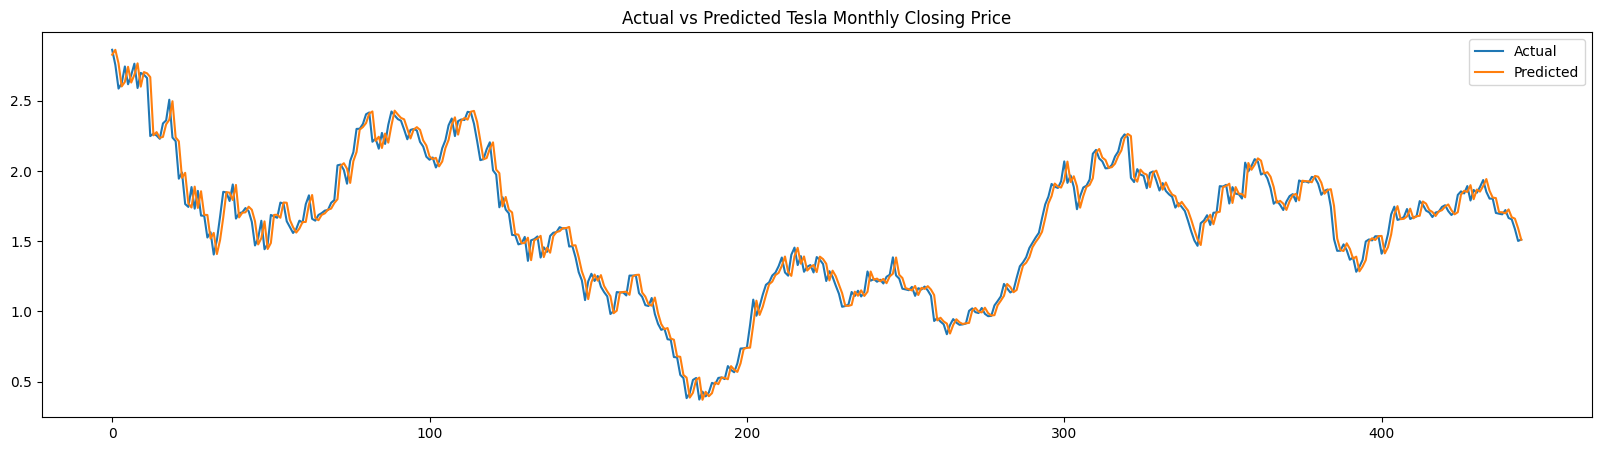

In [26]:
evaluate_model(model_lnr, X_test_scaled, y_test_scaled)

In [27]:
joblib.dump(model_lnr, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_lnr.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_lnr.pkl']

# Neural Nerwork

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.optimizers import Adam


# 2. Define the model
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1)  # Output: next month's closing price
])

# 3. Compile
model_nn.compile(
    optimizer=Adam(0.001),
    loss='mse',  # regression problem
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 4. Train with early stopping
# early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history_nn = model_nn.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=40,
    batch_size=16,
    # callbacks=[early_stop],
    verbose=1
)

Epoch 1/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1247 - root_mean_squared_error: 0.3440 - val_loss: 3.8550 - val_root_mean_squared_error: 1.9634
Epoch 2/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0371 - root_mean_squared_error: 0.1924 - val_loss: 1.3893 - val_root_mean_squared_error: 1.1787
Epoch 3/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0197 - root_mean_squared_error: 0.1401 - val_loss: 0.0611 - val_root_mean_squared_error: 0.2471
Epoch 4/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0163 - root_mean_squared_error: 0.1274 - val_loss: 0.1458 - val_root_mean_squared_error: 0.3819
Epoch 5/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085 - val_loss: 0.2583 - val_root_mean_squared_error: 0.5082
Epoch 6/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0108 - root_mean_squared_error: 0.1038 - val_loss: 0.1940 - val_root_mean_squared_error: 0.4405
Epoch 7/40
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss:

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.21
RMSE: 0.23
R² Score: 0.77


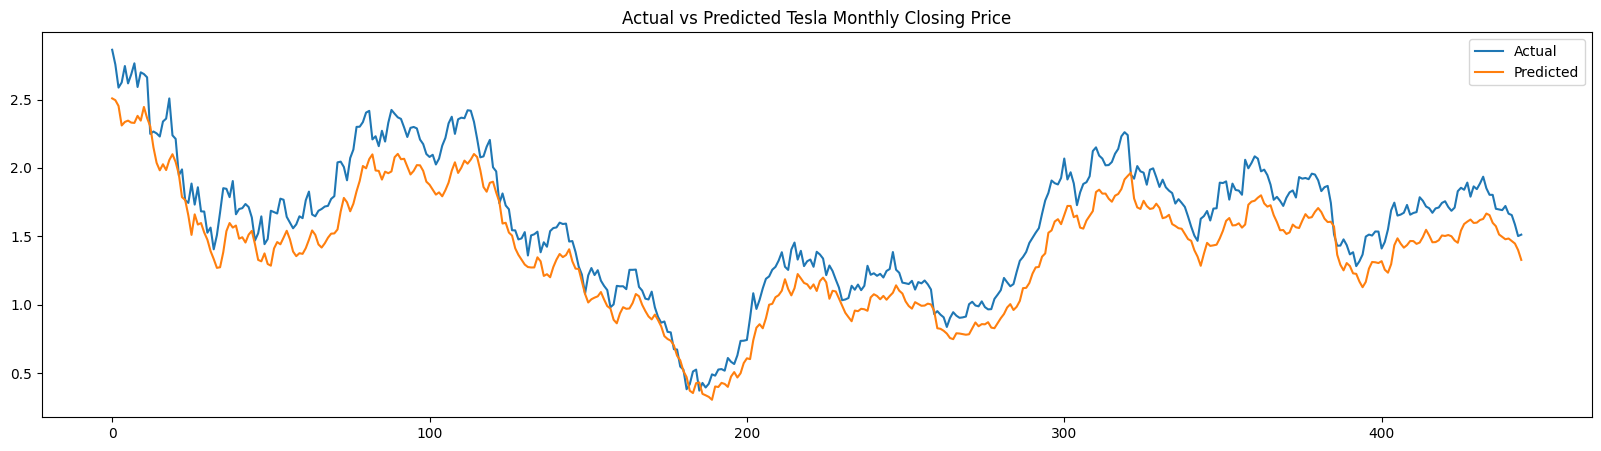

In [35]:
evaluate_model(model_nn, X_test_scaled, y_test_scaled)

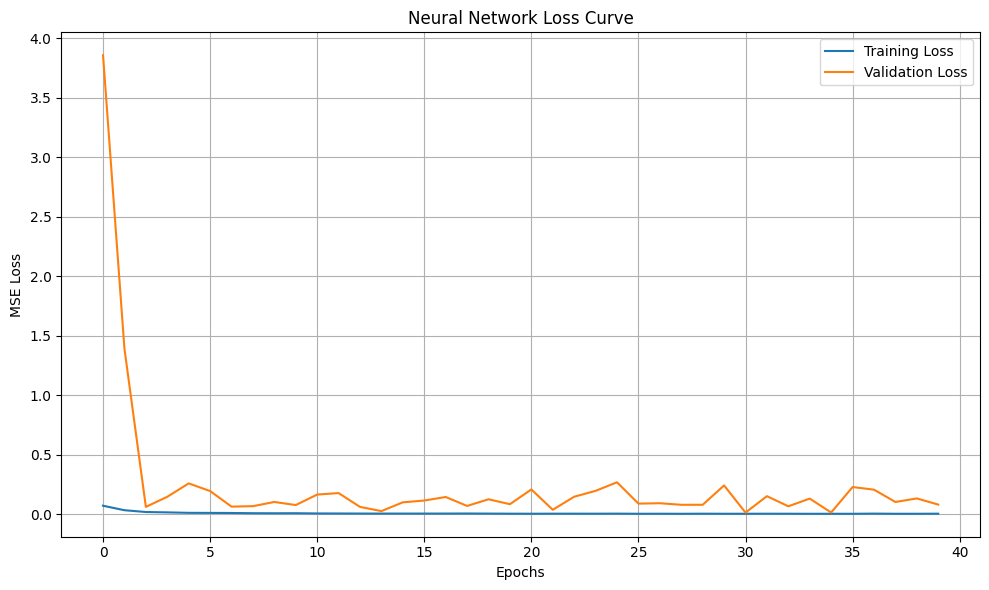

In [36]:
loss_curve(history_nn)

In [37]:
joblib.dump(model_nn, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_nn.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_nn.pkl']